<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ridge Regression</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparison</a></span></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Benchmark</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#inner-or-sum" data-toc-modified-id="inner-or-sum-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span><code>inner</code> or <code>sum</code></a></span></li><li><span><a href="#einsum-or-sum" data-toc-modified-id="einsum-or-sum-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span><code>einsum</code> or <code>sum</code></a></span></li></ul></li></ul></div>

# Implementation

In [1]:
import numpy as np
class LinearRegression:
    
    def __init__(self):
        pass
     
    def fitQR(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X, mode='reduced')
        W=np.linalg.solve(R, Q.T.dot(y))
        self.coeff_=W

    def fitSVD(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        U,D,VT=np.linalg.svd(X, full_matrices=False)
        W=VT.T.dot((1/D*U.T.dot(y)))
        self.coeff_=W
        
    
    def fit(self,X,y):
        self.fitSVD(X,y)
        
    def predict(self, X):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        return np.dot(X,self.coeff_)
        
        
class Ridge:
    
    def __init__(self,alpha=0.0):
        self.alpha_ = alpha
        pass
    
    def fit(self,X,y):
        self.fitSVD(X,y)
    

    def fitSVD(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        U,D,VT=np.linalg.svd(X, full_matrices=False)
        invD=1/(np.square(D)+self.alpha_)*D
        W=VT.T.dot(invD*U.T.dot(y))
        self.coeff_=W
                
    def predict(self, X):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        return np.dot(X,self.coeff_)

class Lasso:
    
    def __init__(self,alpha=0.0):
        self.alpha_ = alpha
        pass
    
    def fit(self,X,y):

        nfeatures=X.shape[1]
        
        W=np.zeros(nfeatures,dtype=X.dtype)        
        b=0
        
        XTX=X.T.dot(X)
        assert XTX.shape == (nfeatures,nfeatures)
        
        #Bs=np.einsum("ij,ij->j", X, X)
        #assert Bs.shape == (nfeatures,)
        
        XTy=X.T.dot(y)
        assert XTy.shape == (nfeatures,)
        
        XT1=np.sum(X, axis=0)
        assert XT1.shape == (nfeatures,)
        
        y_mean = np.mean(y)
        
        for it in range(100):
            for f in range(nfeatures):
                
                A=XTy[f]-XTX[f].dot(W)-b*XT1[f]+XTX[f][f]*W[f]
                B=XTX[f][f]                
                                
                if A > self.alpha_:
                    weight=(A-self.alpha_)/B
                elif A < -self.alpha_:
                    weight=(A+self.alpha_)/B
                else:
                    weight=0.0
                    
                W[f]=weight

            b=y_mean-XT1.dot(W)/X.shape[0]                
            
        self.coeff_=np.append(W,b)
                            
    def predict(self, X):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        return np.dot(X,self.coeff_)



# Linear Regression

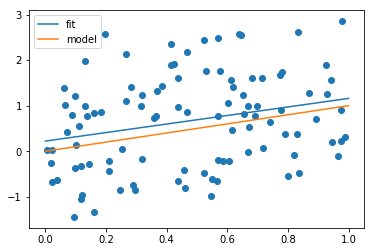

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def get_data(M=1,N=100):
    np.random.seed(0)
    X=np.random.rand(N,M)
    w=np.arange(1,M+1)
    y=np.sum(w.reshape(1,M)*X, axis=1) + np.random.randn(N)
    return X,y,np.append(w,0)

def test_learner(lr):
        
    X,y,w=get_data(1,100)
    lr.fit(X,y)

    X_plt=np.linspace(0,1,50)
    yhat_plt=lr.predict(X_plt)

    fig=plt.figure()
    plt.scatter(X, y)
    plt.plot(X_plt, yhat_plt,label="fit")
    plt.plot(X_plt, X_plt[:]*w[0]+w[1],label="model")
    plt.legend()
    plt.show()

lr=LinearRegression()
test_learner(lr)


# Ridge Regression

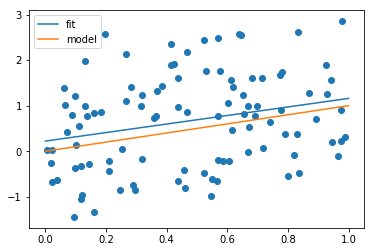

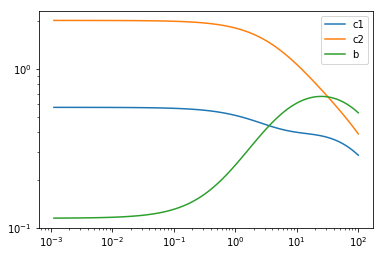

In [3]:
test_learner(Ridge())

def test_shrinkage(cls):
    X,y,w=get_data(2,100)
    cs=[]
    alphas=[]
    for i in range(100):
        alpha=100*np.power(0.1, 5*0.01*i)
        lr=cls(alpha)
        lr.fit(X, y)
        cs.append(alpha)
        alphas.append(lr.coeff_)

    alphas=np.array(alphas)

    plt.figure()
    plt.loglog(cs, alphas[:,0], label="c1")
    plt.loglog(cs, alphas[:,1], label="c2")
    plt.loglog(cs, alphas[:,2], label="b")
    plt.legend()
    plt.show()

    
test_shrinkage(Ridge)


# Lasso

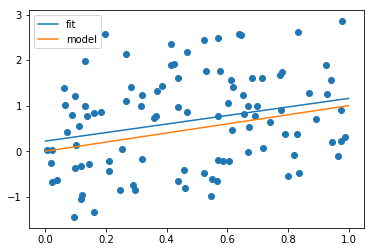

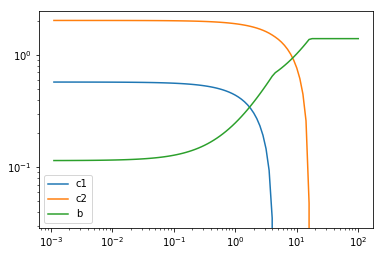

In [4]:
test_learner(Lasso())
test_shrinkage(Lasso)

# Comparison

In [5]:
X,y,w=get_data(2,100)
print("[weights,b]", w)

lr=LinearRegression()
lr.fit(X,y)
print(lr.coeff_)

lr=Ridge(0)
lr.fit(X,y)
print(lr.coeff_)

lr=Ridge(1)
lr.fit(X,y)
print(lr.coeff_)


lr=Lasso(0)
lr.fit(X,y)
print(lr.coeff_)

lr=Lasso(1)
lr.fit(X,y)
print(lr.coeff_)

[weights,b] [1 2 0]
[0.57370044 2.02957506 0.11450326]
[0.57370044 2.02957506 0.11450326]
[0.51064036 1.81731532 0.24778687]
[0.57370044 2.02957506 0.11450325]
[0.43843626 1.89786088 0.24815736]


# Benchmark

## Linear Regression

In [6]:
import numpy as np
        
class LinearRegression1:
    
    def __init__(self):
        pass
    
    def fit(self,X,y):
        fitSVD1(X,y)
    
    def fitInv1(self, X, y):
        '''
        W=(X^T X)^-1 X^T y
        calculate from left to right
        '''
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        W=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.coeff_=W

    def fitInv2(self, X, y):        
        '''
        W=(X^T X)^-1 X^T y
        calculate from right to left
        '''
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        W=np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
        self.coeff_=W

    def fitInv3(self, X, y):        
        '''
        W=(X^T X)^-1 X^T y
        calculate from right to left
        '''
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        W=np.linalg.solve(X.T.dot(X), X.T.dot(y))
        self.coeff_=W
        
    def fitQR1(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X.T.dot(X))
        W=np.linalg.inv(R).dot(Q.T.dot(X.T.dot(y)))
        self.coeff_=W

    def fitQR2(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X, mode='reduced')
        W=np.linalg.inv(R).dot(Q.T.dot(y))
        self.coeff_=W

    def fitQR3(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X, mode='reduced')
        W=np.linalg.solve(R, Q.T.dot(y))
        self.coeff_=W

    def fitSVD1(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        U,D,VT=np.linalg.svd(X, full_matrices=False)
        W=VT.T.dot((1/D*U.T.dot(y)))
        self.coeff_=W

N=1000
M=10
np.random.seed(0)
X=np.random.rand(N,M)
w=np.arange(M)
w=np.power(w,1)
y=np.sum(w.reshape(1,M)*X, axis=1) + np.random.randn(N)

lr=LinearRegression1()

lr.fitQR1(X,y)
print(lr.coeff_)
lr.fitQR2(X,y)
print(lr.coeff_)
lr.fitQR3(X,y)
print(lr.coeff_)

lr.fitInv1(X,y)
print(lr.coeff_)
lr.fitInv2(X,y)
print(lr.coeff_)
lr.fitInv3(X,y)
print(lr.coeff_)

lr.fitSVD1(X,y)
print(lr.coeff_)

linear=LinearRegression()
linear.fit(X,y)
print(linear.coeff_)

ridge=Ridge()
ridge.fit(X,y)
print(ridge.coeff_)

lasso=Lasso()
lasso.fit(X,y)
print(lasso.coeff_)

import sklearn as sk
import sklearn.linear_model
sklr=sk.linear_model.LinearRegression()
sklasso=sk.linear_model.Lasso()
skridge=sk.linear_model.Ridge()

print("LinearRegression")
%timeit linear.fit(X,y)
print("Ridge")
%timeit ridge.fit(X,y)
print("Lasso")
%timeit lasso.fit(X,y)
print("sk LinearRegression")
%timeit sklr.fit(X,y)
print("sk Ridge")
%timeit skridge.fit(X,y)
print("sk Lasso")
%timeit sklasso.fit(X,y)


print("linear inv XTX")
%timeit lr.fitInv1(X,y)
%timeit lr.fitInv2(X,y)
%timeit lr.fitInv3(X,y)
print("linear QR")
%timeit np.linalg.qr(X)
%timeit lr.fitQR1(X,y)
%timeit lr.fitQR2(X,y)
%timeit lr.fitQR3(X,y)
print("linear SVD")
%timeit lr.fitSVD1(X,y)
%timeit lr.fitSVD1(X,y)
%timeit lr.fitSVD1(X,y)


[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.86685136  5.08281453
  5.84551664  7.01901397  7.92140524  8.83446845  0.23926682]
[-0.13699284  1.03452305  1.98131832  2.95835867  3.866

## Lasso

In [7]:
class Lasso1:
    
    def __init__(self,alpha=0.0):
        self.alpha_ = alpha
        pass
                
    def fit(self,X,y):

        nfeatures=X.shape[1]
        
        W=np.zeros(nfeatures,dtype=X.dtype)        
        b=0
        
        for it in range(100):
            for f in range(nfeatures):
                residual=y-X.dot(W)-b+X[:,f]*W[f]
                x=X[:,f]
                A=np.sum(residual*x)
                B=np.sum(np.square(x))
                #print('A',A)
                #print('B',B)
                if A > self.alpha_:
                    weight=(A-self.alpha_)/B
                elif A < -self.alpha_:
                    weight=(A+self.alpha_)/B
                else:
                    weight=0.0
                W[f]=weight

            residual=y-X.dot(W)
            b=residual.mean()

        self.coeff_=np.append(W,b)
                
    def predict(self, X):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        return np.dot(X,self.coeff_)


N=1000
M=10
np.random.seed(0)
X=np.random.rand(N,M)
w=np.arange(M)
w=np.power(w,1)
y=np.sum(w.reshape(1,M)*X, axis=1) + np.random.randn(N)

lasso0=Lasso()
lasso.fit(X,y)
print(lasso.coeff_)

lasso1=Lasso1()
lasso.fit(X,y)
print(lasso.coeff_)

%timeit lasso.fit(X,y)
%timeit lasso1.fit(X,y)

[-0.13694932  1.03451856  1.98128697  2.95814519  3.86692335  5.08312933
  5.84598238  7.01970256  7.92231814  8.83593838  0.23739356]
[-0.13694932  1.03451856  1.98128697  2.95814519  3.86692335  5.08312933
  5.84598238  7.01970256  7.92231814  8.83593838  0.23739356]
3.88 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.8 ms ± 463 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## `inner` or `sum`

In [8]:
N=1000
x=np.random.randn(N)
%timeit np.sum(x*x)
%timeit np.sum(np.square(x))
%timeit np.dot(x,x)
%timeit np.inner(x,x)
%timeit np.linalg.norm(x,ord=2)**2


4.82 µs ± 90.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.1 µs ± 80.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
809 ns ± 6.17 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
842 ns ± 7.55 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
4.44 µs ± 10.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## `einsum` or `sum` 

In [9]:
N=2
X=np.random.randn(N,N)
print(np.sum(X*X, axis=0))
print(np.einsum("ij,ij->j",X,X))

N=100
X=np.random.randn(N,N)
%timeit np.sum(X*X, axis=0)
%timeit np.einsum("ij,ij->j",X,X)


[8.31991292 3.78045401]
[8.31991292 3.78045401]
15.3 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.32 µs ± 45.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
